## Objective: Explore Instacart order data in order to determine where there are business opportunities for growth.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None

Import all Instacart files and do some EDA.

In [6]:
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
order_products__prior = pd.read_csv('order_products__prior.csv')
order_products__train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

Note: Dataset is orders **over time**. 

In [9]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [11]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [13]:
order_products__prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [15]:
order_products__train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [18]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [20]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


Something to note about these tables:

1. difference between order_products__prior and order_products__train is that for any customer, there are between 4 and 100 orders detailed. The last order per customer is put into the train set. The orders prior to the last are put into the prior set.

2. In the orders table, there is an eval_set column that details which set the order belongs to: prior, train or test.

After looking at all tables' columns, can see that they all relate. The orders table can be linked to aisles, departments, products and order_products__prior based on shared columns. Therefore, for each order listed, there is information on what product was picked, in what sequence it was picked if a customer picked a series of items to be added to cart prior to checkout, how long it had been since the customer's last ordered, at what time in the week/day did the customer pick the item what aisle and department the aisle came from and last but not least, whether or not the product was reordered. The last feature is the most important because that is our target value for our eventual model to predict if an item is bought again.

Before building the model, let us explore some of the peaks and tails of some of this data. This will give us a preliminary look at what are the most/least popular picked items among customers, peak times of orders, etc. Let's start!

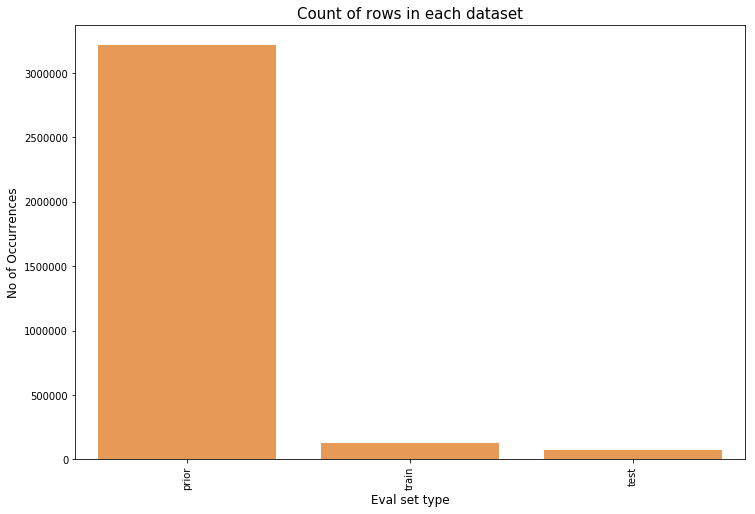

In [26]:
cnt_srs = orders.eval_set.value_counts()

plt.figure(figsize = (12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color = color[1])
plt.ylabel('No of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

This is the breakdown of how many rows from orders are in each evaluation set: prior/train/test. Prior has the most.

In [27]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders.groupby('eval_set')['user_id'].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

This is an output of unique customers. 206,209 in total with 131,209 as the training set to predict for 75,000 customers.

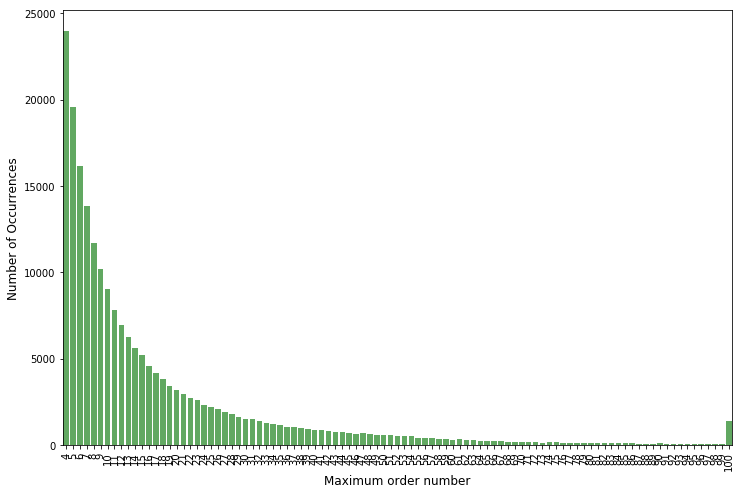

In [28]:
cnt_srs = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

It is verified that for each customer, the amount of orders are between 4 and 100.

Let us explore customer buying habits within a week as well as within a day (hours).

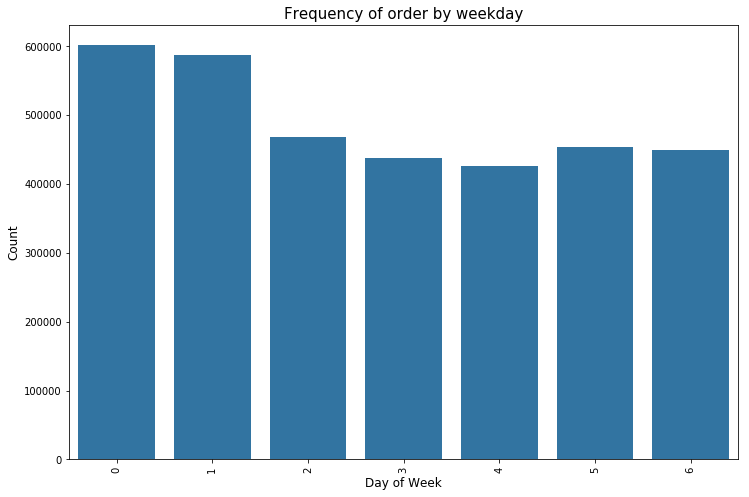

In [29]:
plt.figure(figsize=(12,8))
sns.countplot(x='order_dow', data=orders,color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of Week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of order by weekday', fontsize=15)
plt.show()

**Saturday** and **Sunday** have the heaviest orders, which make sense since this is when people usually get their errands done. Whereas Wednesday has the lowest count which is not a surprise since people usually buy groceries for the whole week.

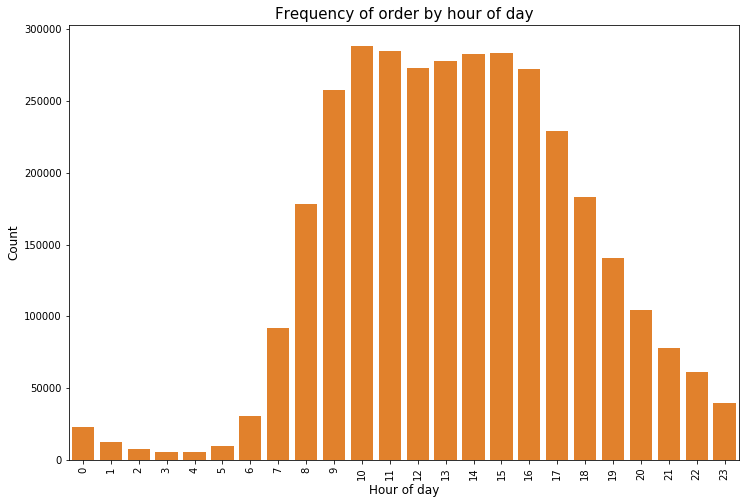

In [32]:
plt.figure(figsize=(12,8))
sns.countplot(x='order_hour_of_day', data=orders, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of order by hour of day', fontsize=15)
plt.show()

Winner is **10AM** hour with bulk of orders made between **9AM and 4PM**.

In order to make things more interesting, will graph hour of day versus day in week to see where the concentration of orders are with this frame of time.